In [17]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

In [18]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
class ActorNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
    
    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return F.softmax(self.output(x),dim=-1) #-1 to take softmax of last dimension

In [20]:
class PGAgent():
    def __init__(self, state_size, action_size, hidden_size, learning_rate, discount ):
        self.action_size = action_size
        self.actor_net = ActorNet(state_size, action_size, hidden_size).to(device)
        self.optimizer = optim.Adam(self.actor_net.parameters(), lr=learning_rate)
        self.discount = discount
        
    def select_action(self, state):
        #get action probs then randomly sample from the probabilities
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action_probs = self.actor_net(input_state)
            #detach and turn to numpy to use with np.random.choice()
            action_probs = action_probs.detach().cpu().numpy()
            action = np.random.choice(np.arange(self.action_size), p=action_probs)
        return action

    def train(self, state_list, action_list, reward_list):
        
        #turn rewards into return
        trajectory_len = len(reward_list)
        return_array = np.zeros((trajectory_len,))
        g_return = 0.
        for i in range(trajectory_len-1,-1,-1):
            g_return = reward_list[i] + self.discount*g_return
            return_array[i] = g_return
            
        # create tensors
        state_t = torch.FloatTensor(state_list).to(device)
        action_t = torch.LongTensor(action_list).to(device).view(-1,1)
        return_t = torch.FloatTensor(return_array).to(device).view(-1,1)
        
        selected_action_prob = self.actor_net(state_t).gather(1, action_t)
        loss = torch.mean(-torch.log(selected_action_prob) * return_t)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step() 

        return loss.detach().cpu().numpy()

In [21]:
# initialize environment
env = gym.make('LunarLander-v2')
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# set seed
seed = 31
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
episodes = 1000 # run agent for this many episodes
hidden_size = 256 # number of units in NN hidden layers
learning_rate = 0.0005 # learning rate for optimizer
discount = 0.99 # discount factor gamma value
reward_scale = 0.01 #scale reward by this amount

# create agent
agent = PGAgent(state_size, action_size, hidden_size, learning_rate, discount)
        

In [22]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0

for ep in range(episodes):
    state, _ = env.reset()
    stats_loss = 0.
    
    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  
    
    state_list = []
    action_list = []
    reward_list = []
    
    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()
        # select an action from the agent's policy
        action = agent.select_action(state)
        
        # enter action into the env
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        episode_length += 1
        # store agent's trajectory
        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward*reward_scale)
        
        # end episode early
        if total_reward < -250:
            done = 1
        
        if done:
            stats_loss += agent.train(state_list, action_list, reward_list)
            stats_rewards_list.append((ep, total_reward, episode_length))
            total_reward = 0
            episode_length = 0  
            if ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Loss: {:.3f}'.format(stats_loss/stats_every))
            break
        
        state = next_state

Episode: 0 Timestep: 59 Total reward: -109.2 Episode length: 59.0 Loss: -0.105
Episode: 10 Timestep: 985 Total reward: -163.4 Episode length: 92.6 Loss: -0.167
Episode: 20 Timestep: 1906 Total reward: -162.8 Episode length: 92.1 Loss: -0.088
Episode: 30 Timestep: 3025 Total reward: -191.1 Episode length: 111.9 Loss: -0.097
Episode: 40 Timestep: 4030 Total reward: -127.0 Episode length: 100.5 Loss: -0.100
Episode: 50 Timestep: 5209 Total reward: -177.4 Episode length: 117.9 Loss: -0.041
Episode: 60 Timestep: 6181 Total reward: -145.2 Episode length: 97.2 Loss: -0.176
Episode: 70 Timestep: 7145 Total reward: -143.7 Episode length: 96.4 Loss: -0.190
Episode: 80 Timestep: 8028 Total reward: -131.3 Episode length: 88.3 Loss: -0.068
Episode: 90 Timestep: 8985 Total reward: -116.6 Episode length: 95.7 Loss: -0.053
Episode: 100 Timestep: 10034 Total reward: -148.1 Episode length: 104.9 Loss: -0.056
Episode: 110 Timestep: 11014 Total reward: -115.7 Episode length: 98.0 Loss: -0.106
Episode: 120

Text(0, 0.5, 'Episode Reward')

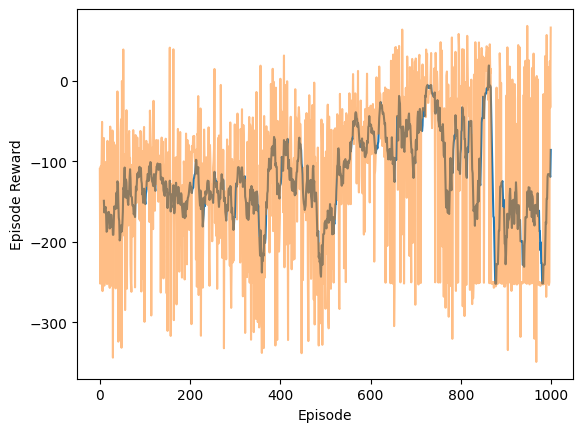

In [23]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

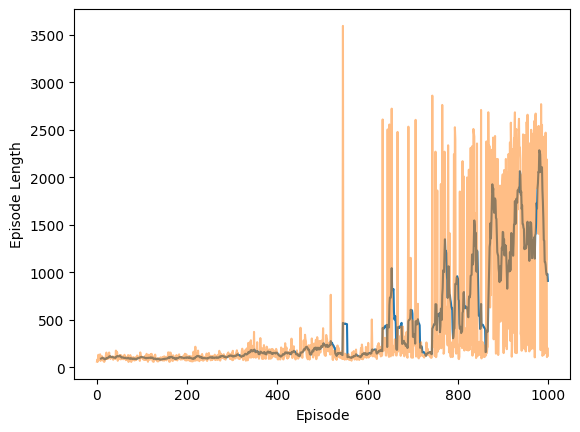

In [24]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')